In [26]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn as sns
# the first time to build font cache
from plotnine import *
# control the working directory
print(os.getcwd())

# data import and pandas manipulation
fp_savi = "../input.savi.txt"
cutoff_refdepth_B = 20
cutoff_altdepth_B = 1
cutoff_freq = 5

# function 1 
raw_data = pd.read_csv(fp_savi, delimiter="\t", index_col=False)
#print(raw_data.describe())

df_savi = raw_data.loc[lambda df:(df["refdepth_Blood"] >= cutoff_refdepth_B) & 
                                 (df["altdepth_Blood"] <= cutoff_altdepth_B) & 
                                 (df["Sgt1_max_frequency"] >= cutoff_freq), :]
df_savi = df_savi.fillna(0)

fp_output = "./"
df_savi.to_csv(fp_output+'test.txt', index=None, sep='\t')
#print(df_savi.columns)

/Users/jihongtang/Documents/GitHub/CELLO/CELLOP


In [27]:
genelist_selected = ['LTBP4', 'PTPN11', 'NF1', 'RB1', 'PDGFRA',
                     'PIK3CG', 'PIK3R1', 'PIK3CA', 'PTEN', 'EGFR', 'IDH1', 'ATRX', 'TP53']
genelist = pd.DataFrame(np.array(genelist_selected), columns=['genelist'])
genelist.to_csv('genelist.txt', index=None, sep='\t')
test = pd.read_csv('genelist.txt', delimiter='\t', index_col=False, header=0)
test.genelist.to_list()

['LTBP4',
 'PTPN11',
 'NF1',
 'RB1',
 'PDGFRA',
 'PIK3CG',
 'PIK3R1',
 'PIK3CA',
 'PTEN',
 'EGFR',
 'IDH1',
 'ATRX',
 'TP53']

In [28]:
# Cell for function mutStats preparation 
# function 2 
df_savi = df_savi
genelist_selected = ['LTBP4', 'PTPN11', 'NF1', 'RB1', 'PDGFRA','PIK3CG', 'PIK3R1', 'PIK3CA', 'PTEN', 'EGFR', 'IDH1', 'ATRX', 'TP53']
cutoff_freq = 5
remove_LOW = True

# remove the synonymous variant labelled by LOW in feature Effect_Impact
if(remove_LOW):
    df_savi = df_savi.loc[lambda df: df["Effect_Impact"] != 'LOW', :]

# pandas Series object ==> list data structure
case = df_savi["CaseID"].drop_duplicates().tolist()

# counting different mutations
mut_P = [0] * len(case)
mut_R = [0] * len(case)
mut_C = [0] * len(case)

# use lambda function to count mutations in different type
for i in range(len(case)):
    mut_C[i] = (lambda df: (df["CaseID"] == case[i]) 
                            & (df["Primary_freq"] >= cutoff_freq) 
                            & (df["Recurrent_freq"] >= cutoff_freq)
                )(df_savi).sum()
    mut_P[i] = (lambda df: (df["CaseID"] == case[i]) 
                            & (df["Primary_freq"] >= cutoff_freq) 
                            & (df["Recurrent_freq"] < cutoff_freq)
                )(df_savi).sum()
    mut_R[i] = (lambda df: (df["CaseID"] == case[i]) 
                            & (df["Primary_freq"] < cutoff_freq) 
                            & (df["Recurrent_freq"] >= cutoff_freq)
                )(df_savi).sum()

df_mut_num = pd.DataFrame({'Patient': case,
                            'Primary': mut_P,
                            'Common': mut_C,
                            'Recurrent': mut_R})


In [29]:
# create 2D list in python using following format to make sure to create several 
# separate lists in the second dimension
list_mut_gene = [['N'] * len(genelist_selected) for _ in range(len(case))]
df_savi_gene = df_savi[df_savi.Gene_Name.isin(genelist_selected)]

geneSel = genelist_selected
for i in range(len(case)):
    for j in range(len(geneSel)):
        temp_P = df_savi_gene.Primary_freq[(df_savi_gene.CaseID == case[i]) & (df_savi_gene.Gene_Name == geneSel[j])]
        temp_R = df_savi_gene.Recurrent_freq[(df_savi_gene.CaseID == case[i]) & (df_savi_gene.Gene_Name == geneSel[j])]
        if any(temp_P >= cutoff_freq) & any(temp_R >= cutoff_freq): 
            list_mut_gene[i][j] = 'C'
        elif any(temp_P >= cutoff_freq):
            list_mut_gene[i][j] = 'P'
        elif any(temp_R >= cutoff_freq):
            list_mut_gene[i][j] = 'R'
        else:
            list_mut_gene[i][j] = 'N'

df_mut_gene = pd.DataFrame(np.array(list_mut_gene), columns=geneSel)
df_mut_gene.index = case


In [30]:
# funciton 3 


In [31]:
# function 4
# co-mutation analysis 
df_mut_gene = df_mut_gene
cutoff_pValue = 0.1
# use replace function and regular expression to generate Primary and Recurrent pattern matrix
mt_mut_P = df_mut_gene.replace(
    r'[C, P]', 1, regex=True).replace(r'[R, N]', 0, regex=True)
mt_mut_R = df_mut_gene.replace(
    r'[C, R]', 1, regex=True).replace(r'[P, N]', 0, regex=True)

# prepare the data of co-mutation analysis
list_columns = list(df_mut_gene.columns)
plot_mutCor = [[0] * 4 for _ in range(len(list_columns)**2)]
idx = 0
for i in range(len(df_mut_gene.columns)):
    for j in range(len(df_mut_gene.columns)):
        plot_mutCor[idx][0] = list_columns[i]
        plot_mutCor[idx][1] = list_columns[j]

        mt_FEtest = np.array([[0,0], [0,0]]) # initial the matrix for fisher exact test
        if i > j: # primary tumor section
            mt_FEtest[0][0] = sum((mt_mut_P.iloc[:,i] == 1)
                                  & (mt_mut_P.iloc[:,j] == 1))
            mt_FEtest[0][1] = sum((mt_mut_P.iloc[:,i] == 1)
                                  & (mt_mut_P.iloc[:,j] == 0))
            mt_FEtest[1][0] = sum((mt_mut_P.iloc[:,i] == 0)
                                  & (mt_mut_P.iloc[:,j] == 1))
            mt_FEtest[1][1] = sum((mt_mut_P.iloc[:,i] == 0)
                                  & (mt_mut_P.iloc[:,j] == 0))
            idx_coMutation = ((mt_FEtest[0][0]+1) * (mt_FEtest[1][1]+1)) / \
                ((mt_FEtest[0][1]+1) * (mt_FEtest[1][0]+1))
            
            # fisher exact test
            odds, pValue = fisher_exact(mt_FEtest, alternative='two-sided')

            if pValue < cutoff_pValue:
                plot_mutCor[idx][2] = -np.log10(pValue) + 1 # for dot size, if the pvalue is lager than cutoff value, fill in instinct value
                if idx_coMutation > 1:
                    plot_mutCor[idx][3] = 'D_red'
                else:
                    plot_mutCor[idx][3] = 'A_blue'
            else:
                plot_mutCor[idx][2] = 1
                plot_mutCor[idx][3] = 'C_grey'

        elif i < j: # recurrent tumor section
            mt_FEtest[0][0] = sum((mt_mut_R.iloc[:, i] == 1)
                                  & (mt_mut_R.iloc[:, j] == 1))
            mt_FEtest[0][1] = sum((mt_mut_R.iloc[:,i] == 1)
                                  & (mt_mut_R.iloc[:,j] == 0))
            mt_FEtest[1][0] = sum((mt_mut_R.iloc[:,i] == 0)
                                  & (mt_mut_R.iloc[:,j] == 1))
            mt_FEtest[1][1] = sum((mt_mut_R.iloc[:,i] == 0)
                                  & (mt_mut_R.iloc[:,j] == 0))
            idx_coMutation = ((mt_FEtest[0][0]+1) * (mt_FEtest[1][1]+1)) / \
                ((mt_FEtest[0][1]+1) * (mt_FEtest[1][0]+1))
            
            # fisher exact test
            odds, pValue = fisher_exact(mt_FEtest, alternative='two-sided')

            if pValue < cutoff_pValue:
                plot_mutCor[idx][2] = -np.log10(pValue) + 1 # for dot size, if the pvalue is lager than cutoff value, fill in instinct value
                if idx_coMutation > 1:
                    plot_mutCor[idx][3] = 'E_black'
                else:
                    plot_mutCor[idx][3] = 'B_green'
            else:
                plot_mutCor[idx][2] = 1
                plot_mutCor[idx][3] = 'C_grey'
        
        else: # i==j, fill all with 'NA'
            plot_mutCor[idx][2] = np.NaN
            plot_mutCor[idx][3] = np.NaN
        
        idx += 1 # add the index for plot table 

df_mutCorMatrix = pd.DataFrame(np.array(plot_mutCor), columns=['listA', 'listB', 'dotSize', 'dotColor'])


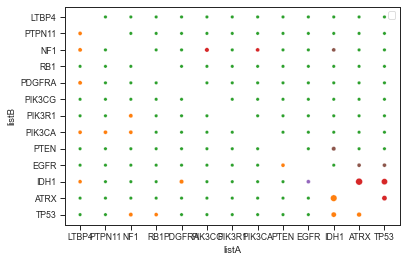

In [32]:
# function 4 visulization
for i in range(len(df_mutCorMatrix)):
    df_mutCorMatrix.dotSize[i] = round(float(df_mutCorMatrix.dotSize[i]), 3)
sns.set_style('ticks')
sns.set_context('paper')
sns.scatterplot(data=df_mutCorMatrix, x='listA',
                y='listB', hue='dotColor', size='dotSize')
plt.legend('')

In [33]:
# function 5 3-D bubble plot of mutation frequency
# data matrix generation
df_savi = df_savi
genelist_selected = genelist_selected
df_mut_gene = df_mut_gene
cutoff_freq = 5

# remove the synonymous variant labelled by LOW in feature Effect_Impact
df_savi = df_savi.loc[lambda df: df["Effect_Impact"] != 'LOW', :]
# pandas Series object ==> list data structure
case = df_savi["CaseID"].drop_duplicates().tolist()

# 13 * 3 matrix initial
mt_mutFreq = [[0] * 3 for _ in range(len(genelist_selected))]
for i in range(len(genelist_selected)):
    df_savi_gene = df_savi[df_savi.Gene_Name == genelist_selected[i]]
    mt_mutFreq[i][0] = len(df_savi_gene.CaseID[(df_savi_gene.Primary_freq >= cutoff_freq) & (
        df_savi_gene.Recurrent_freq < cutoff_freq)].drop_duplicates())
    mt_mutFreq[i][1] = len(df_savi_gene.CaseID[(df_savi_gene.Primary_freq < cutoff_freq) & (
        df_savi_gene.Recurrent_freq >= cutoff_freq)].drop_duplicates())
    mt_mutFreq[i][2] = sum(df_mut_gene.iloc[:, i] == 'C')

df_mutFreq = pd.DataFrame(np.array(mt_mutFreq), columns=[
                          'Primary', 'Recurrent ', 'Common'])
df_mutFreq.index = genelist_selected

print(df_mutFreq)

        Primary  Recurrent   Common
LTBP4         0           9       0
PTPN11        1           2       2
NF1           4          12      10
RB1           1           2       2
PDGFRA        2           3       1
PIK3CG        2           1       5
PIK3R1        1           3       3
PIK3CA        1           4       6
PTEN          5          10      15
EGFR          9           5       9
IDH1          0           1      18
ATRX          5           4      16
TP53          8          13      31


In [34]:
# function 5 - 3D bubble plot visulization


In [35]:
# function 6 - HM analysis
# 4a data
cutoff_mut_freq = 15
cutoff_mut_num = 300
cutoff_HM_score = 1.3

# initilize the parameters 
cutoff_varPresent = cutoff_mut_freq
cutoff_mutLoad = cutoff_mut_num
cutoff_HMscore = cutoff_HM_score

case = df_savi.CaseID.drop_duplicates().tolist()

# initilize all the useful list objects
mutLoad_P = [0] * len(case)
mutLoad_R = [0] * len(case)
HMscore_P = [0] * len(case)
HMscore_R = [0] * len(case)
savi_P = np.array([0] * len(df_savi)) # use numpy arry for futher multiple change 
savi_R = np.array([0] * len(df_savi)) # use numpy arry for futher multiple change 
savi_isHM = np.array([0] * len(df_savi))

# assign three features to gain the new HM df for further calculation
df_savi_HM = df_savi.assign(isC2T=lambda df: 
                            ((df.ref == 'C') & (df.alt == 'T')) | 
                            ((df.ref == 'G') & (df.alt == 'A')))
df_savi_HM = df_savi_HM.assign(isCC2TC=lambda df:
                            ((df.ref == 'C') & (df.alt == 'T') & (df.varSurffix == 'C')) |
                            ((df.ref == 'G') & (df.alt == 'A') & (df.varSurffix == 'G')))                            
df_savi_HM = df_savi_HM.assign(isCT2TT=lambda df:
                               ((df.ref == 'C') & (df.alt == 'T') & (df.varSurffix == 'T')) |
                               ((df.ref == 'G') & (df.alt == 'A') & (df.varSurffix == 'A')))
df_savi_HM.index = range(len(df_savi_HM)) # change the index for further filtering work 
psedcount = 1 # parameter for HM score calculation

for i in range(len(case)): # for each patient 
    df_patient = df_savi_HM[df_savi_HM.CaseID == case[i]]
    
    # primary 
    df_varP = df_patient[(df_patient.Blood_freq == 0) & 
                         (df_patient.Primary_freq > cutoff_varPresent)]
    num_varP = len(df_varP)
    savi_P[df_varP.index.values] = [1] * len(df_varP) # numpy array benefits here
    mutLoad_P[i] = num_varP

    # HM score calculation part IMPORTANT
    pC2T = sum(df_varP.isC2T) / (mutLoad_P[i] + psedcount)
    pCC2TC = sum(df_varP.isCC2TC) / (sum(df_varP.isC2T) + psedcount)
    pCT2TT = sum(df_varP.isCT2TT) / (sum(df_varP.isC2T) + psedcount)
    # IMPORTANT
    HMscore_P[i] = pC2T + pCC2TC + np.sign(pCC2TC - pCT2TT) * pCT2TT

    # recurrent
    df_varR = df_patient[(df_patient.Blood_freq == 0) &
                         (df_patient.Recurrent_freq > cutoff_varPresent)]
    num_varR = len(df_varR)
    savi_R[df_varR.index.values] = [1] * len(df_varR)  # numpy array benefits here
    mutLoad_R[i] = num_varR

    # HM score calculation part IMPORTANT
    rC2T = sum(df_varR.isC2T) / (mutLoad_R[i] + psedcount)
    rCC2TC = sum(df_varR.isCC2TC) / (sum(df_varR.isC2T) + psedcount)
    rCT2TT = sum(df_varR.isCT2TT) / (sum(df_varR.isC2T) + psedcount)
    # IMPORTANT
    HMscore_R[i] = rC2T + rCC2TC + np.sign(rCC2TC - rCT2TT) * rCT2TT

HMmark_P = [0] * len(case)
HMmark_R = [0] * len(case)


for i in range(len(case)):
    if (mutLoad_P[i] > cutoff_mutLoad) & (HMscore_P[i] > cutoff_HMscore):
        savi_isHM[df_savi_HM.CaseID == case[i]] = 1
        HMmark_P[i] = 1
    
    if (mutLoad_R[i] > cutoff_mutLoad) & (HMscore_R[i] > cutoff_HMscore):
        savi_isHM[df_savi_HM.CaseID == case[i]] = 1
        HMmark_R[i] = 1

# temporary list to gain the result DataFrame
tmp_list = []
tmp_list.append(case * 2) # CaseID
tmp_arr1 = np.array(mutLoad_P) + 1
tmp_arr2 = np.array(mutLoad_R) + 1
tmp_list.append(np.concatenate((tmp_arr1, tmp_arr2))) # mutation number
tmp_list.append(HMscore_P + HMscore_R) # HM score
tmp_list.append(HMmark_P + HMmark_R) # HM mark 
tmp_list.append(['P'] * len(case) + ['R'] * len(case)) # PR mark

df_HM_Detection = pd.DataFrame(np.array(tmp_list).T, columns=
                               ['caseID', 'mutNumber', 'HMscore', 'HMmark', 'PRmark'])


/Users/jihongtang/Library/Python/3.8/lib/python/site-packages/plotnine/scales/scale.py:699: RuntimeWarning: divide by zero encountered in log2
/Users/jihongtang/Library/Python/3.8/lib/python/site-packages/plotnine/scales/scale.py:699: RuntimeWarning: invalid value encountered in log2
/Users/jihongtang/Library/Python/3.8/lib/python/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


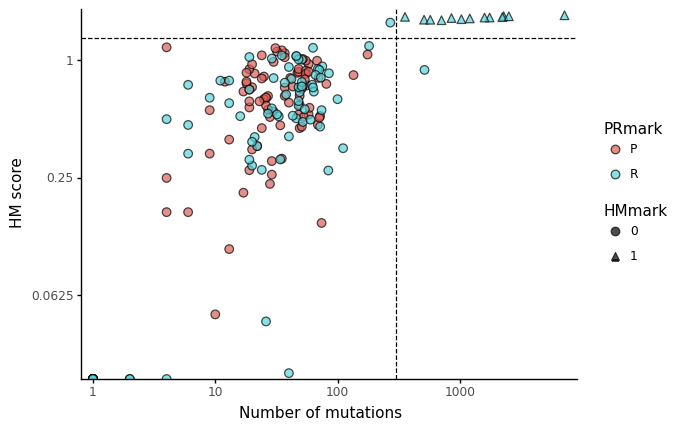

<ggplot: (304844532)>

In [36]:
# function 6 HM analysis
# 4a plot
#print(df_HM_Detection.head())
for i in range(len(df_HM_Detection)):
    df_HM_Detection.HMscore[i] = round(float(df_HM_Detection.HMscore[i]), 3)
    df_HM_Detection.mutNumber[i] = int(df_HM_Detection.mutNumber[i])

ggplot(aes(x='mutNumber', y='HMscore', fill='PRmark', shape='HMmark'), 
                 data=df_HM_Detection) + theme_classic() + \
            geom_point(color="black", size=3, alpha=0.7, stroke=0.5) + \
            ylab('HM score') + xlab('Number of mutations') + ggtitle('') + \
            scale_x_continuous(trans='log10', expand=[0, 0.1]) + \
            scale_y_continuous(trans='log2', expand=[0, 0.1]) + \
            geom_hline(aes(yintercept=cutoff_HMscore), color='black', size=.5, linetype='dashed') + \
            geom_vline(aes(xintercept=cutoff_mutLoad), color='black', size=.5, linetype='dashed') 
#plot_HM.save('test.pdf', width=6, height=6) 
#plot_4a = ggplot(data=df_HM_Detection) + geom_point(aes(x='mutNumber', y='HMscore', fill = 'PRmark', shape = 'HMmark')) + ylab('HM score') + xlab('Number of mutations') + theme_classic()

#from plotnine.data import mpg
#sns.scatterplot(data=mpg, x='cyl', y='cyl')
#sns.scatterplot(data=df_HM_Detection, x='mutNumber', y='HMscore')


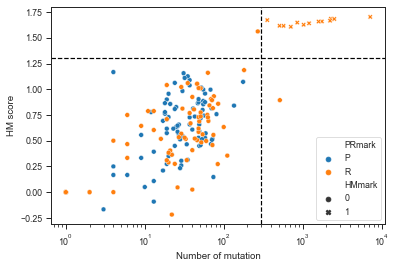

In [37]:
# function 6 HM analysis 
# 4a plot
for i in range(len(df_HM_Detection)):
    df_HM_Detection.HMscore[i] = round(float(df_HM_Detection.HMscore[i]), 3)
    df_HM_Detection.mutNumber[i] = int(df_HM_Detection.mutNumber[i])

sns.set_style('ticks')
sns.set_context('paper')
sns.scatterplot(data=df_HM_Detection, x='mutNumber', y='HMscore', hue='PRmark', style='HMmark')
plt.axhline(y=cutoff_HMscore, color='black', linestyle='--')
plt.axvline(x=cutoff_mutLoad, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Number of mutation')
plt.ylabel('HM score')
plt.legend()


In [38]:
# function 6 HM analysis
# 4b data 
subTypes_P = df_savi_HM[savi_P == 1]
subTypes_R = df_savi_HM[(savi_isHM == 0) & (savi_R == 1)]
subTypes_HR = df_savi_HM[(savi_isHM == 1) & (savi_R == 1)]

# for primary
mut_CTGA_P = sum(((subTypes_P.ref == 'C') & (subTypes_P.alt == 'T')) |
                 ((subTypes_P.ref == 'G') & (subTypes_P.alt == 'A')))
mut_CGGC_P = sum(((subTypes_P.ref == 'C') & (subTypes_P.alt == 'G')) |
                 ((subTypes_P.ref == 'G') & (subTypes_P.alt == 'C')))
mut_CAGT_P = sum(((subTypes_P.ref == 'C') & (subTypes_P.alt == 'A')) |
                 ((subTypes_P.ref == 'G') & (subTypes_P.alt == 'T')))
mut_ATTA_P = sum(((subTypes_P.ref == 'A') & (subTypes_P.alt == 'T')) |
                 ((subTypes_P.ref == 'T') & (subTypes_P.alt == 'A')))
mut_AGTC_P = sum(((subTypes_P.ref == 'A') & (subTypes_P.alt == 'G')) |
                 ((subTypes_P.ref == 'T') & (subTypes_P.alt == 'C')))
mut_ACTG_P = sum(((subTypes_P.ref == 'A') & (subTypes_P.alt == 'C')) |
                 ((subTypes_P.ref == 'T') & (subTypes_P.alt == 'G')))
sumMut_P = sum([mut_CTGA_P, mut_CGGC_P, mut_CAGT_P, 
               mut_ATTA_P, mut_AGTC_P, mut_ACTG_P])


# for recurrent without hypermutation
mut_CTGA_R = sum(((subTypes_R.ref == 'C') & (subTypes_R.alt == 'T')) |
                 ((subTypes_R.ref == 'G') & (subTypes_R.alt == 'A')))
mut_CGGC_R = sum(((subTypes_R.ref == 'C') & (subTypes_R.alt == 'G')) |
                 ((subTypes_R.ref == 'G') & (subTypes_R.alt == 'C')))
mut_CAGT_R = sum(((subTypes_R.ref == 'C') & (subTypes_R.alt == 'A')) |
                 ((subTypes_R.ref == 'G') & (subTypes_R.alt == 'T')))
mut_ATTA_R = sum(((subTypes_R.ref == 'A') & (subTypes_R.alt == 'T')) |
                 ((subTypes_R.ref == 'T') & (subTypes_R.alt == 'A')))
mut_AGTC_R = sum(((subTypes_R.ref == 'A') & (subTypes_R.alt == 'G')) |
                 ((subTypes_R.ref == 'T') & (subTypes_R.alt == 'C')))
mut_ACTG_R = sum(((subTypes_R.ref == 'A') & (subTypes_R.alt == 'C')) |
                 ((subTypes_R.ref == 'T') & (subTypes_R.alt == 'G')))
sumMut_R = sum([mut_CTGA_R, mut_CGGC_R, mut_CAGT_R,
               mut_ATTA_R, mut_AGTC_R, mut_ACTG_R])

# for recurrent with hypermutation
mut_CTGA_HR = sum(((subTypes_HR.ref == 'C') & (subTypes_HR.alt == 'T')) |
                 ((subTypes_HR.ref == 'G') & (subTypes_HR.alt == 'A')))
mut_CGGC_HR = sum(((subTypes_HR.ref == 'C') & (subTypes_HR.alt == 'G')) |
                 ((subTypes_HR.ref == 'G') & (subTypes_HR.alt == 'C')))
mut_CAGT_HR = sum(((subTypes_HR.ref == 'C') & (subTypes_HR.alt == 'A')) |
                 ((subTypes_HR.ref == 'G') & (subTypes_HR.alt == 'T')))
mut_ATTA_HR = sum(((subTypes_HR.ref == 'A') & (subTypes_HR.alt == 'T')) |
                 ((subTypes_HR.ref == 'T') & (subTypes_HR.alt == 'A')))
mut_AGTC_HR = sum(((subTypes_HR.ref == 'A') & (subTypes_HR.alt == 'G')) |
                 ((subTypes_HR.ref == 'T') & (subTypes_HR.alt == 'C')))
mut_ACTG_HR = sum(((subTypes_HR.ref == 'A') & (subTypes_HR.alt == 'C')) |
                 ((subTypes_HR.ref == 'T') & (subTypes_HR.alt == 'G')))
sumMut_HR = sum([mut_CTGA_HR, mut_CGGC_HR, mut_CAGT_HR,
               mut_ATTA_HR, mut_AGTC_HR, mut_ACTG_HR])

tmp_list = []
tmp_list.append(['Primary'] * 6 + ['Rec_noHM'] * 6 + ['Rec_HM'] * 6)
tmp_frac = np.array(
           [mut_CTGA_P, mut_CGGC_P, mut_CAGT_P, 
            mut_ATTA_P, mut_AGTC_P, mut_ACTG_P] + \
           [mut_CTGA_R, mut_CGGC_R, mut_CAGT_R,
            mut_ATTA_R, mut_AGTC_R, mut_ACTG_R] + \
           [mut_CTGA_HR, mut_CGGC_HR, mut_CAGT_HR, 
            mut_ATTA_HR, mut_AGTC_HR, mut_ACTG_HR]
            )
tmp_sum = np.array([sumMut_P] * 6 + [sumMut_R] * 6 + [sumMut_HR] * 6)
tmp_list.append(tmp_frac / tmp_sum)
tmp_list.append(['CTGA', 'CGGC', 'CAGT', 'ATTA', 'AGTC', 'ACTG'] * 3)
df_HM_mutType = pd.DataFrame(np.array(tmp_list).T, columns=[
                             'sampleType', 'Fraction', 'MutType'])
print(df_HM_mutType)

   sampleType               Fraction MutType
0     Primary     0.5913978494623656    CTGA
1     Primary    0.08255289628858828    CGGC
2     Primary    0.11446409989594172    CAGT
3     Primary    0.06312868539715574    ATTA
4     Primary    0.10856746444675686    AGTC
5     Primary    0.03988900450919181    ACTG
6    Rec_noHM     0.6274859008607896    CTGA
7    Rec_noHM    0.07628376372810923    CGGC
8    Rec_noHM     0.1006233303650935    CAGT
9    Rec_noHM    0.04571089344018997    ATTA
10   Rec_noHM    0.12140100920154348    AGTC
11   Rec_noHM   0.028495102404274265    ACTG
12     Rec_HM     0.9708566641682466    CTGA
13     Rec_HM   0.004232617609452846    CGGC
14     Rec_HM   0.006216657113883867    CAGT
15     Rec_HM  0.0034390018076804374    ATTA
16     Rec_HM   0.012521493761298002    AGTC
17     Rec_HM  0.0027335655394382964    ACTG


In [39]:
# function 6 HM analysis 
# 4b plot


In [40]:
# function 6 HM analysis
# 4c data
case = df_savi.CaseID.drop_duplicates().tolist()
ratio_P = [np.NaN] * len(case)
ratio_R = [np.NaN] * len(case)
ratio_HR = [np.NaN] * len(case)

for i in range(len(case)): # for each patient 
    tmp_P = df_savi[(df_savi.CaseID == case[i]) & (savi_P == 1)]
    tmp_R = df_savi[(df_savi.CaseID == case[i]) &
                    (savi_R == 1) & (savi_isHM == 0)]
    tmp_HR = df_savi[(df_savi.CaseID == case[i]) &
                     (savi_R == 1) & (savi_isHM == 1)]
    
    missense_P = sum(['MISSENSE' in strs for strs in tmp_P.Functional_Class])
    silent_P = sum(['SILENT' in strs for strs in tmp_P.Functional_Class])
    missense_R = sum(['MISSENSE' in strs for strs in tmp_R.Functional_Class])
    silent_R = sum(['SILENT' in strs for strs in tmp_R.Functional_Class])
    missense_HR = sum(['MISSENSE' in strs for strs in tmp_HR.Functional_Class])
    silent_HR = sum(['SILENT' in strs for strs in tmp_HR.Functional_Class])

    # filter out the samples that mutations fewer than 10
    if((len(tmp_P) > 10) & (missense_P > 0)): 
        ratio_P[i] = silent_P / missense_P
    if((len(tmp_R) > 10) & (missense_R > 0)):
        ratio_R[i] = silent_R / missense_R
    if((len(tmp_HR) > 10) & (missense_HR > 0)):
        ratio_HR[i] = silent_HR / missense_HR

tmp_list = []
tmp_list.append(['Primary'] * len(ratio_P) + ['Rec_noHM'] * len(ratio_R)
                + ['Rec_HM'] * len(ratio_HR))
tmp_list.append(ratio_P + ratio_R + ratio_HR)
tmp_list.append(['P'] * len(ratio_P) + ['R'] * len(ratio_R) 
                + ['R'] * len(ratio_HR))
df_HM_ratio = pd.DataFrame(np.array(tmp_list).T, columns=[
                           'Groups', 'Ratio', 'PRmark'])
print(df_HM_ratio)

      Groups                 Ratio PRmark
0    Primary  0.030303030303030304      P
1    Primary   0.02564102564102564      P
2    Primary   0.06666666666666667      P
3    Primary   0.15384615384615385      P
4    Primary                   0.0      P
..       ...                   ...    ...
265   Rec_HM                   nan      R
266   Rec_HM                   nan      R
267   Rec_HM                   nan      R
268   Rec_HM                   nan      R
269   Rec_HM                   nan      R

[270 rows x 3 columns]


In [41]:
# function 6 HM analysis
# 4c plot

In [42]:
# function 7 clustering part 
from sklearn.cluster import KMeans

df_mut_num = df_mut_num

tmp_sum = df_mut_num.Primary + df_mut_num.Recurrent + df_mut_num.Common
mt_cluster = np.array([df_mut_num.Primary / tmp_sum,
                      df_mut_num.Recurrent / tmp_sum, df_mut_num.Common / tmp_sum]).T
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(mt_cluster)
df_cluster = pd.DataFrame(mt_cluster, columns=['Primary', 'Recurrence', 'Common'])
clusters = np.array(kmeans.labels_)

# set the cluster feature based on the P R C pattern 
bool_P = (clusters == clusters[df_cluster.Primary == max(df_cluster.Primary)])
bool_R = (clusters == clusters[df_cluster.Recurrence == max(df_cluster.Recurrence)])
bool_C = (clusters == clusters[df_cluster.Common == max(df_cluster.Common)])

clusters[bool_P] = [0] * sum(bool_P)
clusters[bool_R] = [1] * sum(bool_R)
clusters[bool_C] = [2] * sum(bool_C)
df_cluster = df_cluster.assign(Cluster=clusters).assign(id=range(len(df_cluster)))

In [43]:
# function 7 clustering part 
# visualization work 


In [44]:
# function 8 clonal mutation  in selected genes
import re
genelist_selected = genelist_selected
cutoff_freq_low = 5
cutoff_freq_high = 20

# define new which function from R to pandas, code coming from 
# https://alex.miller.im/posts/python-pandas-which-function-indices-similar-to-R/
def which(self):
    try:
        self = list(iter(self))
    except TypeError as e:
        raise Exception("""'which' method can only be applied to iterables.
        {}""".format(str(e)))
    indices = [i for i, x in enumerate(self) if bool(x) == True]
    return(indices)


df_savi = df_savi.loc[lambda df: df["Effect_Impact"] != 'LOW', :]
case = df_savi.CaseID.drop_duplicates().tolist()

caseGene = []
mutType = []
x_content = []
y_content = []
color_factor = []

for i in range(len(case)):  # for each patient
    tmp_case = df_savi[df_savi.CaseID == case[i]]

    for j in range(len(genelist_selected)):
        nameCom = case[i] + '-' + genelist_selected[j]
        tmp_switch = tmp_case[tmp_case.Gene_Name == genelist_selected[j]]
        if any((tmp_switch.Primary_freq <= cutoff_freq_low) & (tmp_switch.Recurrent_freq >= cutoff_freq_high)):
            if any((tmp_switch.Primary_freq >= cutoff_freq_high) & (tmp_switch.Recurrent_freq <= cutoff_freq_low)):
                switch_list = which(((tmp_switch.Primary_freq <= cutoff_freq_low) & (tmp_switch.Recurrent_freq >= cutoff_freq_high)) | (
                    (tmp_switch.Primary_freq >= cutoff_freq_high) & (tmp_switch.Recurrent_freq <= cutoff_freq_low)))
                for k in switch_list:
                    caseGene += [nameCom, nameCom]
                    AAC = re.sub('^ *| *$', '', tmp_switch.Amino_Acid_Change.tolist()[k])
                    if AAC in mutType:
                        tmp = AAC + 'NA'
                        mutType += [tmp, tmp]
                    else:
                        mutType += [AAC, AAC]
                    x_content += ['Primary', 'Recurrence']
                    y_content += [tmp_switch.Primary_freq.tolist()[k], tmp_switch.Recurrent_freq.tolist()[k]]
                    if tmp_switch.Primary_freq.tolist()[k] > tmp_switch.Recurrent_freq.tolist()[k]:
                        color_factor += ['P', 'P']
                    else:
                        color_factor += ['R', 'R'] 

tmp_list = [caseGene, mutType, x_content, y_content, color_factor]
df_switch = pd.DataFrame(np.array(tmp_list).T, columns=[
                         'CaseGene', 'MutType', 'x_content', 'y_content', 'color_factor'])
if len(df_switch) == 0:
    print('No switch event detected in the given gene list!\n')

In [45]:
def mutStats(df_savi, genelist_selected, cutoff_freq, remove_LOW=True):
    """
    Generate mutation count table and selected gene based mutation type table 
    from the prepocessed savi table and return one list object containing two 
    separate DataFrame objects.
    The mutation count table contains the number of different mutation types (C for 
    Common, P for Primary and R for Recurrent) for each patient with unique caseID. 
    The gene based mutation table contains the mutation type for all the provided
    selected gene for each patient.

    Args:
    df_savi (DataFrame): The savi table in DataFrame format from function mutRead()
    genelist_selected (list): The list of selected gene name to generate the gene
        based mutation type table
    cutoff_freq (int): The cutoff number of mutation frequency to be the mutation 
        detection criterion
    remove_LOW (bool, default=True): The logic tag to determine whether removing 
        the synonymous variant labelled by LOW in feature Effect_Impact is necessary

    Returns:
    list(DataFrame, DataFrame) 
    """
    # remove the synonymous variant labelled by LOW in feature Effect_Impact
    if(remove_LOW):
        df_savi = df_savi.loc[lambda df: df["Effect_Impact"] != 'LOW', :]
    
    # pandas Series object ==> list data structure
    case = df_savi["CaseID"].drop_duplicates().tolist()

    # initial the storing list to count different mutations
    mut_P = [0] * len(case)
    mut_R = [0] * len(case)
    mut_C = [0] * len(case)

    # use lambda function to count mutations in different type
    for i in range(len(case)):
        mut_C[i] = (lambda df: (df["CaseID"] == case[i])
                    & (df["Primary_freq"] >= cutoff_freq)
                    & (df["Recurrent_freq"] >= cutoff_freq)
                    )(df_savi).sum()
        mut_P[i] = (lambda df: (df["CaseID"] == case[i])
                    & (df["Primary_freq"] >= cutoff_freq)
                    & (df["Recurrent_freq"] < cutoff_freq)
                    )(df_savi).sum()
        mut_R[i] = (lambda df: (df["CaseID"] == case[i])
                    & (df["Primary_freq"] < cutoff_freq)
                    & (df["Recurrent_freq"] >= cutoff_freq)
                    )(df_savi).sum()

    df_mut_num = pd.DataFrame({'Patient': case,
                                'Primary': mut_P,
                                'Common': mut_C,
                                'Recurrent': mut_R})
    
    # create 2D list in python using following format to make sure to create several
    # separate lists in the second dimension
    list_mut_gene = [['N'] * len(genelist_selected) for _ in range(len(case))]
    df_savi_gene = df_savi[df_savi.Gene_Name.isin(genelist_selected)]

    geneSel = genelist_selected
    for i in range(len(case)):
        for j in range(len(geneSel)):
            temp_P = df_savi_gene.Primary_freq[(df_savi_gene.CaseID == case[i]) & (
                df_savi_gene.Gene_Name == geneSel[j])]
            temp_R = df_savi_gene.Recurrent_freq[(df_savi_gene.CaseID == case[i]) & (
                df_savi_gene.Gene_Name == geneSel[j])]
            if any(temp_P >= cutoff_freq) & any(temp_R >= cutoff_freq):
                list_mut_gene[i][j] = 'C'
            elif any(temp_P >= cutoff_freq):
                list_mut_gene[i][j] = 'P'
            elif any(temp_R >= cutoff_freq):
                list_mut_gene[i][j] = 'R'
            else:
                list_mut_gene[i][j] = 'N'
    
    df_mut_gene = pd.DataFrame(np.array(list_mut_gene), columns=geneSel)
    df_mut_gene.index = case

    return([df_mut_num, df_mut_gene])

In [46]:
# function 9 Infer mutation order in tumor evolutionary history
# data part
genelist_selected = ['LTBP4', 'IDH1', 'ATRX', 'TP53', 'NF1',
                     'MSH6', 'PIK3CG', 'PIK3R1', 'PIK3CA', 'PTEN', 'EGFR']
[df_mut_num, df_mut_gene] = mutStats(df_savi, genelist_selected, 5, True)

In [47]:
# define new which function from R to pandas, code coming from
# https://alex.miller.im/posts/python-pandas-which-function-indices-similar-to-R/
def which(self):
    try:
        self = list(iter(self))
    except TypeError as e:
        raise Exception("""'which' method can only be applied to iterables.
        {}""".format(str(e)))
    indices = [i for i, x in enumerate(self) if bool(x) == True]
    return(indices)

df_input = df_mut_gene
genelist_selected = df_input.columns.tolist()

# calculating TEDG edge table
mt_edge = [[0] * len(genelist_selected) for _ in range(len(genelist_selected))]
list_edge = []

for i in range(len(genelist_selected)-1):
    start = i+1
    for j in range(start, len(genelist_selected)):
        mt_edge[i][j] = sum((df_input.iloc[:, i] == 'C') &
                            (df_input.iloc[:, j].isin(['P', 'R'])))
        mt_edge[j][i] = sum((df_input.iloc[:, j] == 'C') &
                            (df_input.iloc[:, i].isin(['P', 'R'])))
        # ';'.join() is used to combine the case pattern and is similar to paste function in R 
        labelA = ';'.join(df_input.index[which((df_input.iloc[:, i] == 'C') &
                                               (df_input.iloc[:, j].isin(['P', 'R'])))])
        labelB = ';'.join(df_input.index[which((df_input.iloc[:, j] == 'C') &
                                               (df_input.iloc[:, i].isin(['P', 'R'])))])
        
        if mt_edge[i][j] < mt_edge[j][i]:
            mt_edge[i][j] = 0
            edge = [genelist_selected[j], genelist_selected[i], mt_edge[j][i], labelB]
            list_edge.append(edge)
        elif mt_edge[i][j] > mt_edge[j][i]:
            mt_edge[j][i] = 0
            edge = [genelist_selected[i], genelist_selected[j], mt_edge[i][j], labelA]
            list_edge.append(edge)
        else:
            mt_edge[i][j] = 0
            mt_edge[j][i] = 0
df_edge = pd.DataFrame(np.array(list_edge), columns=['geneA', 'geneB', 'weight', 'label'])
print(df_edge.head())

  geneA  geneB weight           label
0  IDH1  LTBP4      3  R027;R049;R055
1  ATRX  LTBP4      1            R049
2  TP53  LTBP4      3  R027;R049;R055
3  PTEN  LTBP4      1            R039
4  EGFR  LTBP4      2       R022;R039


In [48]:
# calculating TEDG node table
from scipy.stats import binom_test
mut_freq = np.array([[0] * len(genelist_selected) for _ in range(3)]).T

for i in range(len(genelist_selected)):
    mut_freq[i][0] = sum(df_input.iloc[:, i] == 'P')
    mut_freq[i][1] = sum(df_input.iloc[:, i] == 'R')
    mut_freq[i][2] = sum(df_input.iloc[:, i] == 'C') * 2

sample_size = [(mut_freq[i][0] + mut_freq[i][1] + mut_freq[i][2])
               for i in range(len(genelist_selected))]

tmp_df = pd.DataFrame(np.array(mt_edge))
ins = [sum(tmp_df.iloc[:, i]> 0) for i in range(len(genelist_selected))]
outs = [sum(tmp_df.iloc[i, :]> 0) for i in range(len(genelist_selected))]

pcdf = [1] * len(genelist_selected)
for i in range(len(pcdf)):
    if ins[i] < outs[i]:
        pcdf[i] = binom_test(x=ins[i], n=ins[i]+outs[i], p=0.5)
    else:
        pcdf[i] = binom_test(x=outs[i], n=ins[i]+outs[i], p=0.5)

fc = np.log2((np.array(outs)+1) / (np.array(ins)+1)) # positive value ==> early; negative value ==> late

tmp_list = [genelist_selected, pcdf, fc, sample_size]
df_node = pd.DataFrame(np.array(tmp_list).T, columns=[
                       'Gene', 'p_CDF', 'FC', 'Occurence'])
print(df_node)


      Gene      p_CDF                   FC Occurence
0    LTBP4     0.0625   -2.584962500721156         9
1     IDH1  0.0078125    3.169925001442312        37
2     ATRX      0.125   1.8073549220576042        35
3     TP53  0.5078125   0.8073549220576041        74
4      NF1      0.375  -1.3219280948873622        34
5     MSH6     0.0625   -2.584962500721156         8
6   PIK3CG       0.25                 -2.0        13
7   PIK3R1        1.0                  0.0        10
8   PIK3CA       0.25                 -2.0        17
9     PTEN        1.0                  0.0        42
10    EGFR      0.375   1.3219280948873624        26


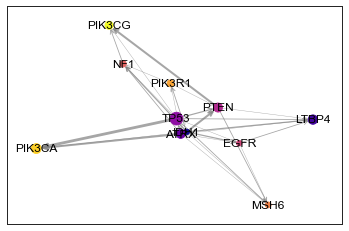

In [49]:
# function 9 visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 423
G = nx.from_pandas_edgelist(df_edge, 'geneA', 'geneB', create_using=nx.DiGraph())
pos = nx.spring_layout(G, seed=seed)
#nx.spiral_layout

#node_count = [float(i) for i in ]
node_sizes = [15 + 2 * float(i) for i in df_node.Occurence.to_list()]
edge_weight = [int(i)/2.5 for i in df_edge.weight.to_list()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=range(G.number_of_nodes()), cmap=plt.cm.plasma)
edges = nx.draw_networkx_edges(
    G, 
    pos,
    node_size = node_sizes,
    arrowstyle= "->", 
    arrowsize=10,
    edge_color="grey",
    width=edge_weight, 
    alpha=0.7
)
labels = nx.draw_networkx_labels(G, pos, font_size=12)
#nx.draw(G, pos, node_size = node_sizes, with_labels = True)
plt.show()

#print(node_sizes)


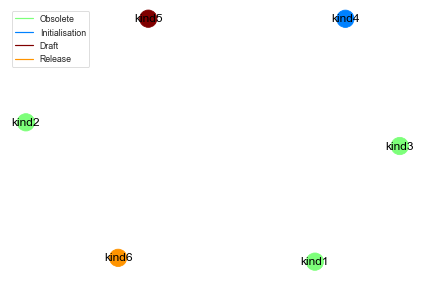

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx

G=nx.Graph()
G.add_node("kind1")
G.add_node("kind2")
G.add_node("kind3")
G.add_node("kind4")
G.add_node("kind5")
G.add_node("kind6")

# You were missing the position.
pos=nx.spring_layout(G)
val_map = {'kind1': 2,'kind2': 2,'kind3': 2,'kind4': 1,'kind5':4,'kind6': 3}
#I had this list for the name corresponding t the color but different from the node name
ColorLegend = {'Obsolete': 2,'Initialisation': 1,'Draft': 4,'Release': 3}
values = [val_map.get(node, 0) for node in G.nodes()]
# Color mapping
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)

# Just fixed the color map
nx.draw_networkx(G,pos, cmap = jet, vmin=0, vmax= max(values),node_color=values,with_labels=True,ax=ax)

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend()

f.tight_layout()
plt.show()